In [1]:
using MatterPower
using Roots
using Plots
using LaTeXStrings
using LinearAlgebra
using Statistics
gr()  # Set GR as the backend

Plots.GRBackend()

In [30]:
module DarkEnergyModule
    using DifferentialEquations
    using PyCall
    using Plots
    using LaTeXStrings
    using QuadGK

    # Import the Python camb module and dark energy submodule
    cb = pyimport("camb")
    DarkEnergyPPF = pyimport("camb.dark_energy").DarkEnergyPPF

    # Define a struct to encapsulate dark energy parameters
    struct DarkEnergyModel
        Ωm::Float64  # Total matter density parameter
        ΩΛ::Float64  # Dark energy density parameter
        w0::Float64  # EoS parameter
        wa::Float64  # Evolution of EoS
        h::Float64   # Hubble constant in units of 100 km/s/Mpc
        pars1::PyObject  # CAMB parameters
        results1::PyObject  # CAMB results
    end

    # Constructor with CAMB setup
    function DarkEnergyModel(Ωm::Float64, ΩΛ::Float64, w0::Float64, wa::Float64, h::Float64)
        # Calculate baryon and cold dark matter densities
        ombh2 = 0.045 * h^2  # Assuming baryon fraction is 0.045
        omch2 = (Ωm - 0.045) * h^2  # Cold dark matter density
        
        # Initialize CAMB parameters
        pars1 = cb.set_params(H0=h * 100, ombh2=ombh2, omch2=omch2, ns=0.965)
        pars2 = cb.set_params(H0=h * 100, ombh2=ombh2, omch2=omch2, ns=0.965)
        
        # Configure matter power and non-linear settings
        pars1["set_matter_power"](redshifts=[0.0], kmax=100.0)
        pars1["NonLinear"] = cb.model["NonLinear_both"] #for linear choose _none
        results1 = cb.get_results(pars1)
        
        return DarkEnergyModel(Ωm, ΩΛ, w0, wa, h, pars1, results1)
    end

    # Dynamical dark energy equation of state
    function DE_EoS(self::DarkEnergyModel, redshift::Float64)
        w0, wa = self.w0, self.wa
        return (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
    end


    # Define methods for the DarkEnergyModel struct
    function growth(self::DarkEnergyModel, a1::Real=1e-2)
        Ωm, ΩΛ, w0, wa = self.Ωm, self.ΩΛ, self.w0, self.wa
        Ωk = 1 - Ωm - ΩΛ
        redshift = 1 / a1 - 1
        DEoS = (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
        E1 = √(Ωm / a1^3 + Ωk / a1^2 + ΩΛ * DEoS)
        u0 = [a1; -a1^2 * E1]
        tspan = (a1, 1.0)
        prob = ODEProblem((du, u, p, a) -> growth_set!(du, u, p, a, w0, wa), u0, tspan, [Ωm, ΩΛ])
        return solve(prob, Tsit5())
    end

    function growth_set!(du, u, p, a, w0, wa)
        δ, θ = u
        Ωm, ΩΛ = p
        Ωk = 1 - Ωm - ΩΛ
        redshift = 1 / a - 1
        DEoS = (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
        E = √(Ωm / a^3 + Ωk / a^2 + ΩΛ * DEoS)  # E(a) = H(a)/H0
        q2ϕ = -(3 / 2) * Ωm * δ / a  # Poisson equation
        du[1] = -θ / a^2 / E  # Continuity equation
        du[2] = -θ / a + q2ϕ / a^2 / E  # Euler equation
    end

    # Redshift-dependent growth factor
    function dz(self::DarkEnergyModel, redshift::Float64)
        sol = growth(self)
        a = 1 / (1 + redshift)
        return sol(a)[1]
    end

# Growth rate calculation
    function growth_rate(self::DarkEnergyModel, redshift::Float64)
        step = 0.01  # Step size for numerical stability
        dzda = (dz(self, redshift + step) - dz(self, redshift - step)) / (2 * step)
        g = - (1 + redshift) * dzda / dz(self, redshift)
        return g
    end

    # Normalized Hubble rate
    function normalized_hubble_rate(self::DarkEnergyModel, redshift::Float64)
        Ωm, ΩΛ = self.Ωm, self.ΩΛ
        Ωk = 1 - Ωm - ΩΛ
        DEoS = DE_EoS(self, redshift)
        return √(Ωm / (1 + redshift)^(-3) + Ωk / (1 + redshift)^(-2) + ΩΛ * DEoS)
    end

    function comoving_distance(self::DarkEnergyModel, redshift::Union{Float64, AbstractArray{Float64}})
        if isa(redshift, Float64)
            # Single redshift
            integrand(z) = 1 / normalized_hubble_rate(self, z)
            result, error = quadgk(integrand, 0, redshift)
            return result * 2997.98 / self.h
        else
            # Array of redshifts: Apply to each redshift
            return [comoving_distance(self, z) for z in redshift]
        end
    end

    # Angular Diameter Comoving distance in MPc
    function comoving_angular_distance(self::DarkEnergyModel, redshift::Float64)
        return comoving_distance(self, redshift)/(1+redshift)
    end

    # Linear power spectrum from CAMB
    function get_power_spectrum(self::DarkEnergyModel, kh::Vector{Float64}, redshift::Float64)
        # Extract matter power spectrum from CAMB
        _, _, pk_lcdm = self.results1["get_matter_power_spectrum"](minkh=minimum(kh), maxkh=maximum(kh), npoints=length(kh))
        # Convert Python arrays to Julia arrays
        pk_lcdm = collect(pk_lcdm)
         # Normalize the power spectrum using dz
        normalized_pk = pk_lcdm * (dz(self, Float64(redshift))^2 / dz(self, 0.0)^2)
    
        return normalized_pk
    end

    export dz, comoving_distance, comoving_angular_distance, DarkEnergyModel, normalized_hubble_rate, get_power_spectrum
end


using .DarkEnergyModule
using Revise


darkenergy = DarkEnergyModule.DarkEnergyModel(0.31, 0.69, -1.0, -0.0, 0.67)


c = 2.998 * 10^5
normalization = 9/4 * darkenergy.Ωm^2 * (darkenergy.h * 100 / c)^4


# Function to apply Simpson's rule on an array
function simps(y, x)
    n = length(x)
    if n < 3 || n % 2 == 0
        error("Simpson's rule requires an odd number of points.")
    end

    dx = (x[end] - x[1]) / (n - 1)
    result = y[1] + y[end] + 4 * sum(y[2:2:end-1]) + 2 * sum(y[3:2:end-2])
    return result * dx / 3
end



simps (generic function with 1 method)

Power spectrum: [408.8267463384983, 457.3507335808645, 511.62567544873167, 572.3297377465163, 640.2197951665929, 716.1399964383759, 801.0304219928461, 895.9382035697768, 1002.0274939211839, 1120.5905892168978, 1253.0593789590055, 1401.018669150946, 1566.2159838810092, 1750.572955257643, 1956.197632906193, 2185.3912284327257, 2440.6569619391375, 2724.700203028593, 3040.431204842709, 3390.951415560998, 3779.5345414049184, 4209.588468635765, 4684.600554415866, 5208.0636489414455, 5783.387116458732, 6413.765438979888, 7102.021361273868, 7850.434719230873, 8660.520558033362, 9532.80739693469, 10466.553262642521, 11459.448194329416, 12507.214691539535, 13603.231732898168, 14737.961171092262, 15899.542108964806, 17070.17271786992, 18229.219392917923, 19350.758532283344, 20405.826350756593, 21358.41889649154, 22167.54815400785, 22788.446361780665, 23173.09254734791, 23273.488645299214, 23046.487503501932, 22461.098787204028, 21508.46139669612, 20213.254860375488, 18642.96457113477, 16910.21255

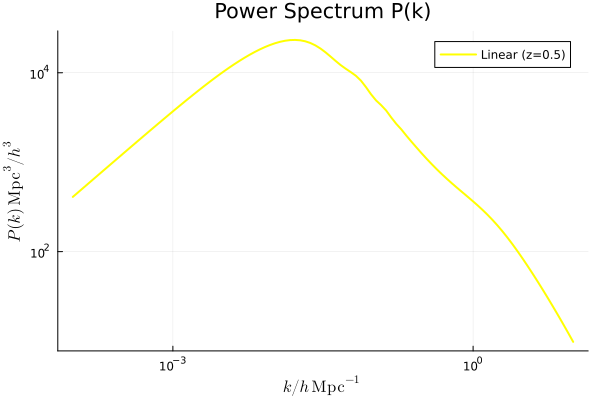

In [32]:
using Plots

# Example kh range and redshift
kh = 10 .^range(-4, stop=1.0, length=100) |> collect  # Create a range of kh values
redshift = 0.0  # Example redshift

# Call the get_power_spectrum function (replace with actual function call)
pk = DarkEnergyModule.get_power_spectrum(darkenergy, kh, redshift)

# Flatten the matrix to extract the first row
pk_flat = pk[1, :]

# Print the power spectrum
println("Power spectrum: ", pk_flat)

# Plot the power spectrum
plot(
    kh, pk_flat,
    label="Linear (z=0.5)",
    color=:yellow, lw=2,
    xlabel=L"k/h \, \mathrm{Mpc}^{-1}",
    ylabel=L"P(k) \, \mathrm{Mpc}^3 / h^3",
    xscale=:log10, yscale=:log10,
    title="Power Spectrum P(k)"
)

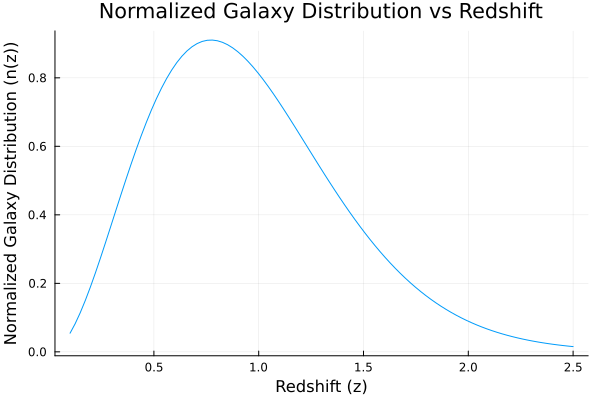

In [36]:
using SpecialFunctions  # For gamma function
using Plots  # For plotting

# Define the normalized galaxy distribution function
function normalized_galaxy_dist(redshift)
    # Parameters for Euclid survey
    alpha = 2
    beta = 1.5
    z0 = 0.6374
    numerator = (1 + alpha) / z0
    denominator = gamma((1 + alpha + beta) / beta)
    exponent = exp(-(redshift / z0)^beta)
    nz = numerator * (redshift / z0)^alpha * exponent / denominator
    return nz
end

# Define the range of redshift values
redshifts = range(0.1, stop=2.5, length=100)

# Compute the galaxy distribution for each redshift
galaxy_dist = [normalized_galaxy_dist(z) for z in redshifts]

# Plot the result
plot(redshifts, galaxy_dist,
    xlabel="Redshift (z)",
    ylabel="Normalized Galaxy Distribution (n(z))",
    title="Normalized Galaxy Distribution vs Redshift",
    legend=false,
    grid=true)

In [38]:
using Statistics
using QuadGK

function kappa_galaxy(ell)
    c = 2.998 * 10^5
    zh = 1.3
    # Kernel 1: Depend on dynamic redshift lower limit
    function kernel1(z_lower, z)
        distances = DarkEnergyModule.comoving_distance(darkenergy, z)
        dist_1000 = DarkEnergyModule.comoving_distance(darkenergy, zh)
        (1 .- distances ./ dist_1000).^2 .* normalized_galaxy_dist(z)
    end

    # Kernel 2: Use kernel1 integration with dynamic lower limit
    function kernel2(z)
        integral_kernel1, _ = quadgk(z_inner -> kernel1(z_inner, z), z, zh)  # Integrate kernel1 from 0.1 to z
        (1 .+ z)^2 .* DarkEnergyModule.dz(darkenergy, z)^2 .* integral_kernel1
    end

    # Kernel 3: Power spectrum and normalized hubble rate
    function kernel3(z)
        distances = DarkEnergyModule.comoving_distance(darkenergy, z)
        kh = ell / distances
        pk = DarkEnergyModule.get_power_spectrum(darkenergy, [kh * 0.999, kh * 1.001], 0.0)
        mean(pk) ./ (DarkEnergyModule.dz(darkenergy, 0.0)^2) ./ 
                  (DarkEnergyModule.normalized_hubble_rate(darkenergy, z) .* 67.7)
    end

    # Full integration for kernel2 and kernel3
    full_kernel(z) = kernel2(z) .* kernel3(z)
    integration_result, _ = quadgk(full_kernel, 0.1, zh)

    # Final result
    return integration_result * normalization * c
end

kappa_galaxy (generic function with 1 method)

In [ ]:
# Define ell values
#llist = 10 .^ range(1, stop=3, length=20) 
#llist = 10 .^ range(log10(10), stop=log10(2000), length=20) 
# Calculate kappa for each ell in llist
#kappa_wl_gal_lin = [kappa_galaxy(ell) for ell in llist]

# Flatten kappa_wl_gal
#kappa_wl_gal_flat_lin = map(x -> x[1], kappa_wl_gal_lin)  # Extract the first element from each nested vector


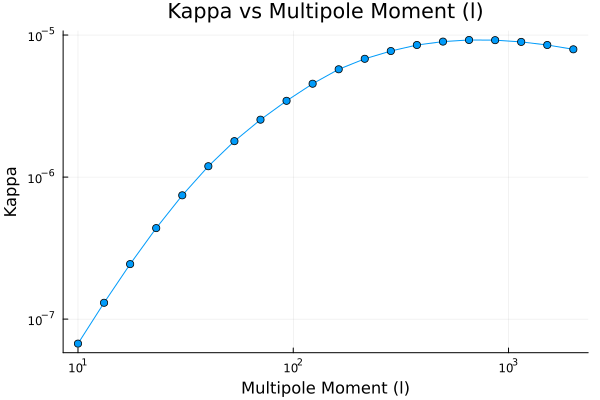

In [84]:
using CSV
using DataFrames


# Create a DataFrame
#df = DataFrame(ell_values=llist, kappa_values=kappa_wl_gal_flat_lin)

# Save to CSV
#CSV.write("kappa_vs_ell.csv", df)

# Read the CSV file
df = CSV.read("kappa_vs_ell.csv", DataFrame)

# Extract columns
ell_values = df.ell_values
kappa_values = df.kappa_values

# Plot the data
plot(ell_values, llist .* (llist .+ 1) .* kappa_values ./ (6.28),
    xscale=:log10,
    yscale=:log10,
    xlabel="Multipole Moment (l)",
    ylabel="Kappa",
    title="Kappa vs Multipole Moment (l)",
    legend=false,
    marker=:circle,
    linestyle=:solid,
    grid=true)

In [40]:
# Define ell values
#llist = 10 .^ range(1, stop=3, length=20) 
llist = 10 .^ range(log10(10), stop=log10(2000), length=20) 
# Calculate kappa for each ell in llist
kappa_wl_gal = [kappa_galaxy(ell) for ell in llist]

# Flatten kappa_wl_gal
kappa_wl_gal_flat = map(x -> x[1], kappa_wl_gal)  # Extract the first element from each nested vector


20-element Vector{Float64}:
 3.8369671256239785e-9
 4.3528621303835525e-9
 4.743293010726548e-9
 4.926555325035616e-9
 4.83931162758547e-9
 4.460721011217499e-9
 3.843403004691015e-9
 3.1170605221702012e-9
 2.4243882345960176e-9
 1.8396988204557677e-9
 1.3528910073453692e-9
 9.52543821595395e-10
 6.588308547125802e-10
 4.5742614302808867e-10
 3.1882231219116535e-10
 2.2641586185570577e-10
 1.6454717194471356e-10
 1.2227130084187355e-10
 9.203118148241097e-11
 6.907805841987758e-11

In [48]:
using CSV
using DataFrames

# Create a DataFrame
df_nonlin = DataFrame(ell_values=llist, kappa_values=kappa_wl_gal_flat)

# Save to CSV
CSV.write("kappa_vs_ell_nonlin.csv", df_nonlin)

"kappa_vs_ell_nonlin.csv"

In [50]:
df_nonlin = CSV.read("kappa_vs_ell_nonlin.csv", DataFrame)

Row,ell_values,kappa_values
,Float64,Float64
1,10.0,3.83697e-9
2,13.2162,4.35286e-9
3,17.4668,4.74329e-9
4,23.0845,4.92656e-9
5,30.509,4.83931e-9
6,40.3213,4.46072e-9
7,53.2894,3.8434e-9
8,70.4284,3.11706e-9
9,93.0796,2.42439e-9


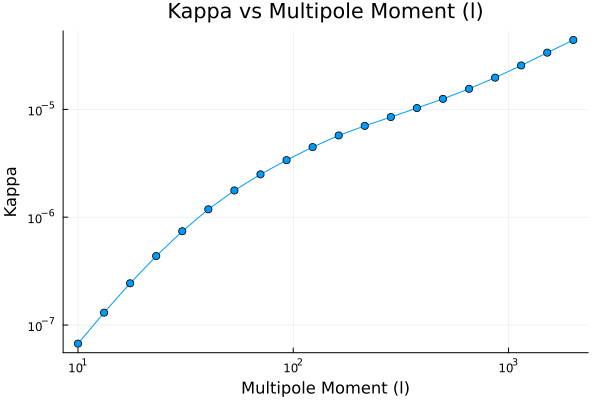

In [78]:

# Extract columns
ell_values = df_nonlin.ell_values
kappa_values_nonlin = df_nonlin.kappa_values

# Plot the data
plot(ell_values, llist .* (llist .+ 1) .* kappa_values_nonlin ./ (6.28),
    xscale=:log10,
    yscale=:log10,
    xlabel="Multipole Moment (l)",
    ylabel="Kappa",
    title="Kappa vs Multipole Moment (l)",
    legend=false,
    marker=:circle,
    linestyle=:solid,
    grid=true)
#plot!(llist, llist .* (llist .+ 1) .* kappa_wl_gal_flat_lin ./ (6.28))

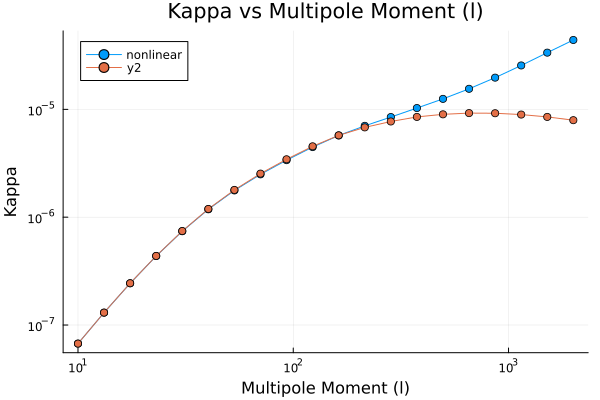

In [88]:
# Plot the data
plot(ell_values, llist .* (llist .+ 1) .* kappa_values_nonlin ./ (6.28),
    xscale=:log10,
    yscale=:log10,
    xlabel="Multipole Moment (l)",
    ylabel="C(L)",
    title="Kappa vs Multipole Moment (l)",
    legend=true,
    label = "Nonlinear",
    marker=:circle,
    linestyle=:solid,
    grid=true)
plot!(ell_values, llist .* (llist .+ 1) .* kappa_values ./ (6.28),
    xscale=:log10,
    yscale=:log10,
    xlabel="Multipole Moment (l)",
    ylabel="Kappa",
    title="Kappa vs Multipole Moment (l)",
    legend=true,
    label = "Linear",
    marker=:circle,
    linestyle=:solid,
    grid=true)

In [90]:

function kappa_cmb(ell)
    c = 2.998 * 10^5
    redshift = range(0.1, stop=1000.0, length=1001)  # Ensure odd number of points for Simpson's rule
    
    # Calculate distances
    dist_1000 = DarkEnergyModule.comoving_distance(darkenergy, 1000.0)
    distances = DarkEnergyModule.comoving_distance.(Ref(darkenergy), redshift)  # Use Ref for broadcasting

    # Calculate kh = ell / distances for each redshift
    kh_values = ell ./ distances

    # Kernel calculations
    kernel1 = (1 .- distances ./ dist_1000).^2
    kernel2 = kernel1 .* (1 .+ redshift).^2 .* 
              DarkEnergyModule.dz.(Ref(darkenergy), redshift).^2 .* 
              map(kh -> begin
                  pk = DarkEnergyModule.get_power_spectrum(darkenergy, [kh * 0.999, kh * 1.001], 0.0)  # Small range for CAMB
                  mean(pk)  # Use the mean value from the small range
              end, kh_values) ./ 
              (DarkEnergyModule.dz(darkenergy, 0.0)^2)
    kernel3 = kernel2 ./ (DarkEnergyModule.normalized_hubble_rate.(Ref(darkenergy), redshift) .* 67.7)

    # Validate input lengths
    @assert length(kernel3) == length(redshift)

    # Integrate using simps
    integration = simps(kernel3, redshift)
    return integration * normalization * c
end

kappa_cmb (generic function with 1 method)

In [100]:
# Define ell values
llist = 10 .^ range(log10(10), stop=log10(2000), length=20)
# Calculate kappa for each ell in llist
kappa_wl = [kappa_cmb(ell) for ell in llist]

20-element Vector{Float64}:
 3.476651697657625e-8
 3.6792673768458176e-8
 3.900088206049785e-8
 4.263551787311894e-8
 4.72740853408568e-8
 5.109925624718393e-8
 5.454126284314304e-8
 5.580924508979712e-8
 5.388104886415054e-8
 4.846076080651395e-8
 4.120921716006185e-8
 3.419358004331047e-8
 2.6927398269961085e-8
 1.9777968854891365e-8
 1.4864194041098142e-8
 1.0490263038083732e-8
 7.300508191935393e-9
 5.058910028641892e-9
 3.5348859982241007e-9
 2.50681469572969e-9

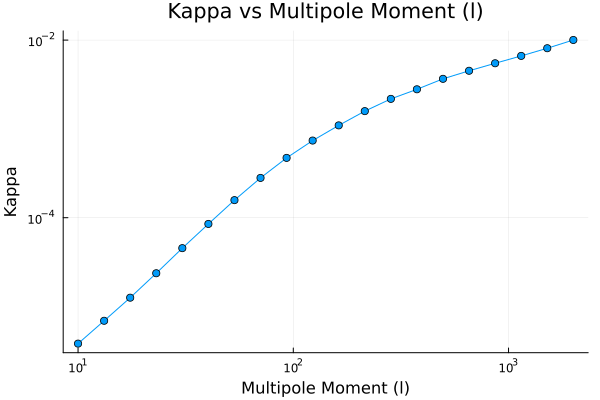

In [102]:

# Flatten kappa_wl
kappa_wl_flat = map(x -> x[1], kappa_wl)  # Extract the first element from each nested vector

# Plot
plot(llist, llist .* (llist .+ 1) .* kappa_wl_flat,
    xscale=:log10,
    yscale=:log10,
    xlabel="Multipole Moment (l)",
    ylabel="Kappa",
    title="Kappa vs Multipole Moment (l)",
    legend=false,
    marker=:circle,
    linestyle=:solid,
    grid=true)


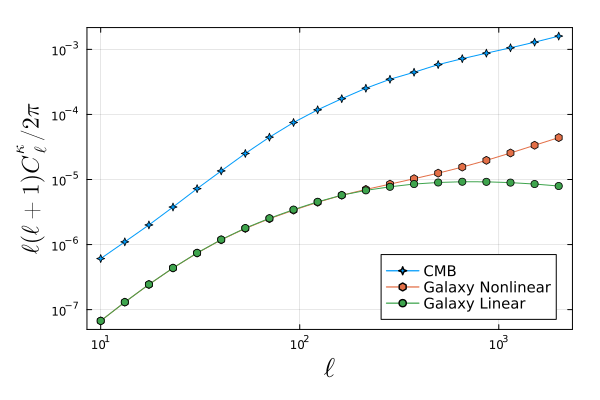

In [171]:
using Plots
using Measures
gr()
plot(llist, llist .* (llist .+ 1) .* kappa_wl_flat./ (6.28),
    xscale=:log10,
    yscale=:log10,
    xlabel="Multipole Moment (l)",
    ylabel="Kappa",
    #title="Kappa vs Multipole Moment (l)",
    label = "CMB",
    legend=true,
    marker=:star4,
    linestyle=:solid,
    grid=true)
# Plot the data
plot!(ell_values, llist .* (llist .+ 1) .* kappa_values_nonlin ./ (6.28),
    xscale=:log10,
    yscale=:log10,
    xlabel="Multipole Moment (l)",
    ylabel="C(L)",
    #title="Kappa vs Multipole Moment (l)",
    legend=true,
    label = "Galaxy Nonlinear",
    marker=:hexagon,
    linestyle=:solid,
    grid=true)
plot!(ell_values, llist .* (llist .+ 1) .* kappa_values ./ (6.28),
    xscale=:log10,
    yscale=:log10,
    yticks=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    xlabel= L"\ell",  # LaTeX format
    ylabel=L"\ell (\ell + 1) C^\kappa_\ell / 2\pi",       # LaTeX format
    #title="Kappa vs Multipole Moment (l)",
    legend=true,
    label = "Galaxy Linear",
    marker=:circle,
    linestyle=:solid,
    grid=true,
    xlabelfontsize=18,  # Increase x-axis label font size
    ylabelfontsize=16,
    margin=5mm)
# Final plot adjustments
plot!(
    framestyle=:box,
    legend=:bottomright,
    legendfontsize=10  # Increase legend font size
)
#savefig("kappa_vs_multipole.pdf")